In [1]:
import tensorflow as tf
import pandas as pd
import multiprocessing
import concurrent.futures
from PIL import Image
import numpy as np
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, BatchNormalization, Dropout, GlobalAveragePooling2D, Activation
from keras.applications import DenseNet201
from keras.models import Model
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
import itertools

In [2]:
image_size=224
def resize_image_array(image_path):
    return np.asarray(Image.open(image_path).resize((image_size,image_size)))
def get_images(df_paths):
    max_workers = multiprocessing.cpu_count()
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        image_arrays = list(executor.map(resize_image_array, ('ISIC_2019/train/' + df_paths['image'] + '.jpg').tolist()))
    return np.array(image_arrays)

In [3]:
def load_data(x_df_path, y_df_path):
    x_df = pd.read_csv(x_df_path)
    y_df = pd.read_csv(y_df_path)
    x_paths = x_df.iloc[:, 0:1]
    y = y_df.iloc[:,:].values
    x_img = get_images(x_paths)
    x_img = np.array(x_img)
    x_img = x_img / 255
    return x_img, y

In [4]:
class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

In [5]:
def build_densenet201():
    base_model = DenseNet201(weights='imagenet',
                             include_top=False,
                             input_tensor=Input(shape=(224, 224, 3))
                            )
    for layer in base_model.layers:
        layer.trainable = False
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(8, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=x)
    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [6]:
X_train, y_train = load_data('X_train_df.csv', 'y_train_df.csv')

In [7]:
X_val, y_val = load_data('X_val_df.csv', 'y_val_df.csv')

In [8]:
X_test, y_test = load_data('X_test_df.csv', 'y_test_df.csv')

In [9]:
batch_size = 32
train_gen = DataGenerator(X_train, y_train, batch_size)
val_gen = DataGenerator(X_val, y_val, batch_size)
test_gen = DataGenerator(X_test, y_test, batch_size)

In [10]:
densenet_model = build_densenet201()

In [11]:
history = densenet_model.fit(train_gen, validation_data=val_gen, epochs=30)

Epoch 1/30
1100/1100 [==============================] - 94s 74ms/step - loss: 1.1544 - accuracy: 0.6143 - val_loss: 1.0511 - val_accuracy: 0.6318
Epoch 2/30
1100/1100 [==============================] - 73s 66ms/step - loss: 0.9769 - accuracy: 0.6448 - val_loss: 0.9760 - val_accuracy: 0.6464
Epoch 3/30
1100/1100 [==============================] - 73s 66ms/step - loss: 0.9115 - accuracy: 0.6631 - val_loss: 0.9323 - val_accuracy: 0.6727
Epoch 4/30
1100/1100 [==============================] - 69s 63ms/step - loss: 0.8735 - accuracy: 0.6808 - val_loss: 0.9068 - val_accuracy: 0.6791
Epoch 5/30
1100/1100 [==============================] - 73s 66ms/step - loss: 0.8456 - accuracy: 0.6888 - val_loss: 0.8847 - val_accuracy: 0.6855
Epoch 6/30
1100/1100 [==============================] - 73s 66ms/step - loss: 0.8250 - accuracy: 0.6982 - val_loss: 0.8782 - val_accuracy: 0.6936
Epoch 7/30
1100/1100 [==============================] - 71s 64ms/step - loss: 0.8087 - accuracy: 0.7045 - val_loss: 0.8687 -

In [12]:
results = densenet_model.evaluate(test_gen)
print("Loss:", results[0])
print("Accuracy:", results[1])

138/138 [==============================] - 8s 58ms/step - loss: 0.8170 - accuracy: 0.7045
Loss: 0.8170298933982849
Accuracy: 0.7045454382896423


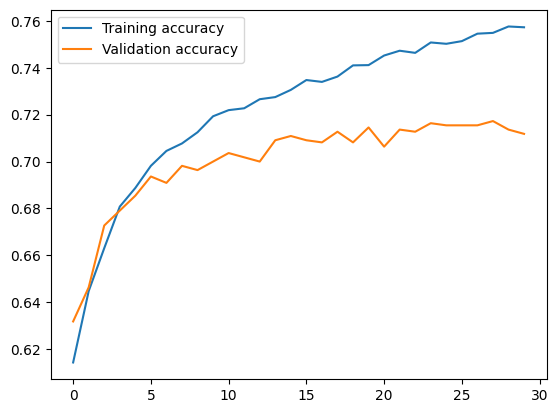

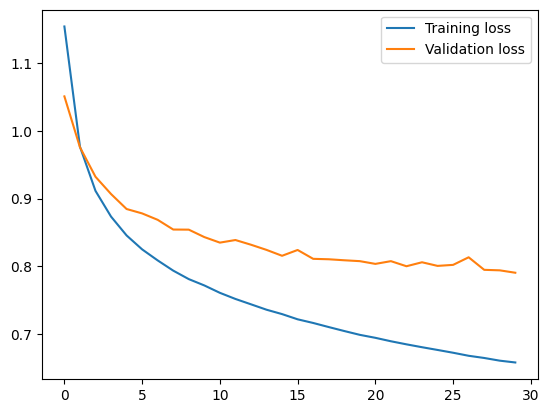

In [13]:
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

In [36]:
def plot_confusion_matrix(y_true, y_pred, diseases, cmap=plt.cm.Blues):
    ConfusionMatrixDisplay.from_predictions(y_pred=y_pred, y_true=y_true, cmap=cmap)
    plt.xticks(np.arange(len(diseases)), diseases, rotation=45)
    plt.yticks(np.arange(len(diseases)), diseases)
    plt.grid(False)
    plt.show()

def plot_normalized_confusion_matrix(y_true, y_pred, diseases):
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_df = pd.DataFrame(cm_normalized, index=diseases, columns=diseases)
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt=".2f", cbar=True)
    plt.xticks(np.arange(len(diseases)) + 0.5, diseases, rotation=45)
    plt.yticks(np.arange(len(diseases)) + 0.5, diseases, rotation=0)
    plt.gca().set_facecolor('lightgray')
    plt.gca().add_patch(plt.Rectangle((0, 0), len(diseases), len(diseases), fill=False, edgecolor='black', lw=2))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

def plot_classification_report(y_true, y_pred, diseases):
    print(classification_report(y_pred=y_pred, y_true=y_true, target_names=diseases))

def print_multiclass_cm_metrics(y_true, y_pred, diseases, printable = False, plottable=True):
    mcm = multilabel_confusion_matrix(y_true=y_true, y_pred=y_pred)
    accuracy = []
    sensitivity = []
    specificity = []
    precision = []
    
    for i in range(len(mcm)):
        tp = mcm[i][1,1]
        tn = mcm[i][0,0]
        fp = mcm[i][0,1]
        fn = mcm[i][1,0]
        current_accuracy = (tp+tn)/(tp+tn+fp+fn)
        current_sensitivity = (tp)/(tp+fn)
        current_specificity = (tn)/(tn+fp)
        current_precision = (tp)/(tp+fp)
        if printable:
            print(f"\tPrecision: {current_precision}")
            print(f"\tSensitivity: {current_sensitivity}")
            print(f"\tSpecificity: {current_specificity}")
            print(f"\tAccuracy: {current_accuracy}")
            print()
        accuracy.append(current_accuracy)
        precision.append(current_precision)
        sensitivity.append(current_sensitivity)
        specificity.append(current_specificity)
    
    width = 0.3
    x = np.arange(len(diseases))
    font_size=6
    if plottable:
        plt.bar(x-width,precision, width = width, label='Precision')
        plt.bar(x, accuracy, width=width, label='Accuracy')
        plt.bar(x+width, sensitivity, width=width, label='Sensitivity')
        for x1, x2, x3, y1, y2, y3 in zip(x-width, x, x+width, precision, accuracy, sensitivity):
            plt.text(x1, y1, '%.2f' % y1, ha='center', va='bottom', fontsize=font_size)
            plt.text(x2, y2, '%.2f' % y2, ha='center', va='bottom', fontsize=font_size)
            plt.text(x3, y3, '%.2f' % y3, ha='center', va='bottom', fontsize=font_size)
        plt.xticks(x, diseases)
        plt.legend(loc='lower left')
        plt.show()

def get_metrics(x_test, y_test, model):
    diseases = ['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC']
    y_pred = model.predict(x_test)
    y_pred = np.argmax(y_pred, axis=1)
    y_true =  np.argmax(y_test, axis=1)
    plot_confusion_matrix(y_true=y_true, y_pred=y_pred, diseases=diseases)
    plot_normalized_confusion_matrix(y_true=y_true, y_pred=y_pred, diseases=diseases)
    plot_classification_report(y_pred=y_pred, y_true=y_true, diseases=diseases)
    print_multiclass_cm_metrics(y_true=y_true, y_pred=y_pred, diseases=diseases)

35/35 [==============================] - 4s 124ms/step


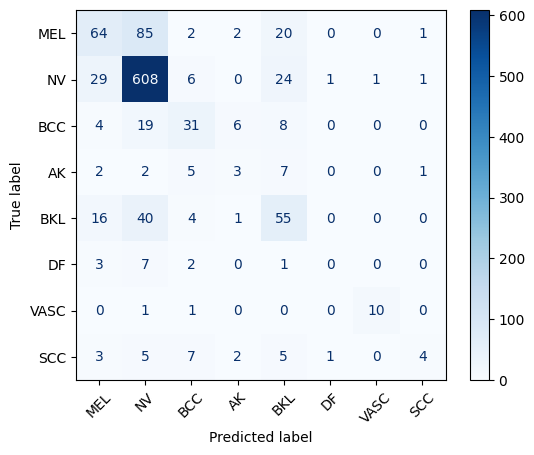

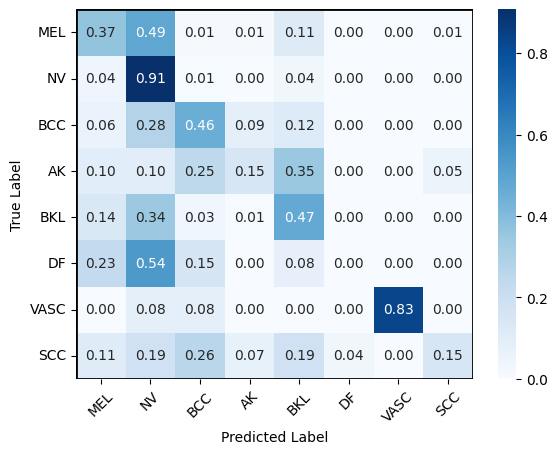

              precision    recall  f1-score   support

         MEL       0.53      0.37      0.43       174
          NV       0.79      0.91      0.85       670
         BCC       0.53      0.46      0.49        68
          AK       0.21      0.15      0.18        20
         BKL       0.46      0.47      0.47       116
          DF       0.00      0.00      0.00        13
        VASC       0.91      0.83      0.87        12
         SCC       0.57      0.15      0.24        27

    accuracy                           0.70      1100
   macro avg       0.50      0.42      0.44      1100
weighted avg       0.68      0.70      0.68      1100



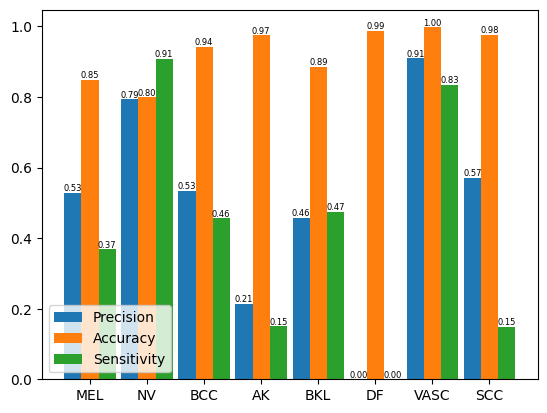

In [37]:
get_metrics(X_test, y_test, densenet_model)

In [16]:
densenet_model.save_weights('basic_densenet201.h5')